In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from hysteresis.base import BaseHysteresis
from hysteresis.training import train_hysteresis
from hysteresis.visualization import plot_hysterion_density

In [2]:

folder = f'D:/APS/Q7Hysteresis'
fnames = ['/APSU_Q7_100017035_MajorHysteresisLoop_0000_000_00_procFld_01.csv',
          '/APSU_Q7_100017035_MinorHysteresisLoop-1_0000_000_00_procFld_01.csv',
          '/APSU_Q7_100017035_MinorHysteresisLoop-2_0000_000_00_procFld_01.csv',
          '/APSU_Q7_100017035_MinorHysteresisLoop-3_0000_000_00_procFld_01.csv',
          '/APSU_Q7_100017035_HysteresisTrial-1_0000_000_00_procFld_01.csv',
          '/APSU_Q7_100017035_HysteresisTrial-2_0000_000_00_procFld_01.csv']

full_data = []
for fname in fnames:
    data = pd.read_csv(folder + fname, skiprows=5)
    data = data.drop([0])
    full_data += [data]

full_data = pd.concat(full_data, ignore_index=True)

# get real h, m
h = torch.tensor(full_data['Current'].to_numpy(dtype=np.float64))
m = torch.tensor(full_data['BigB1'].to_numpy(dtype=np.float64))

0
1000
2000
3000
4000
7411
Parameter containing:
tensor([ 0.1725,  0.0336,  0.0022, -0.0577])
tensor(0.1041, dtype=torch.float64)


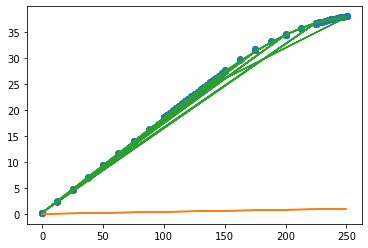

In [3]:
h_train = h.detach()
m_train = m.detach()


# fit using normal hysteresis model
H = BaseHysteresis(h_train,
                   m_train,
                   mesh_scale = 0.1,
                   polynomial_degree=4,
                   polynomial_fit_iterations=5000)
print(len(H.mesh_points))
print(H.transformer._poly_fit.weights)

fig,ax = plt.subplots()
ax.plot(h_train, m_train,'o')
ax.plot(h_train, H(h_train).detach())
ax.plot(h_train, H.transformer.get_fit(h_train))

# calc rms error
error = H.transformer.get_fit(h_train) - m_train
print(torch.std(error))



In [4]:
# train on data
loss_trace = train_hysteresis(H, 5000, lr=0.01, atol=1e-8)

0
1000
2000
3000
4000


tensor(0.0681, dtype=torch.float64)
tensor(0.0679, dtype=torch.float64)
tensor([14.1940], grad_fn=<AddBackward0>)
tensor([15.3463], grad_fn=<AddBackward0>)
tensor([-28.8467], grad_fn=<AddBackward0>)
Parameter containing:
tensor([ 0.1725,  0.0336,  0.0022, -0.0577])


C:\Users\RYANRO~1\AppData\Local\Temp/ipykernel_30432/3853817449.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  print(torch.min(torch.tensor(loss_trace)))


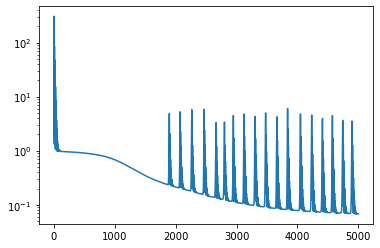

In [5]:
fig, ax = plt.subplots()
ax.semilogy(loss_trace)
print(loss_trace[-1])
print(torch.min(torch.tensor(loss_trace)))
print(H.offset)
print(H.scale)
print(H.slope)
print(H.transformer._poly_fit.weights)

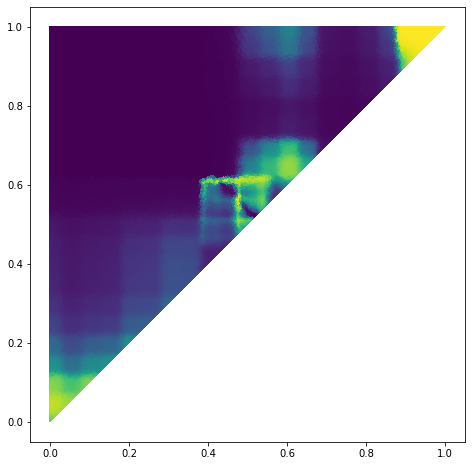

In [6]:
fig, ax,c  = plot_hysterion_density(H)
ax.set_aspect('equal')
fig.set_size_inches(8,8)

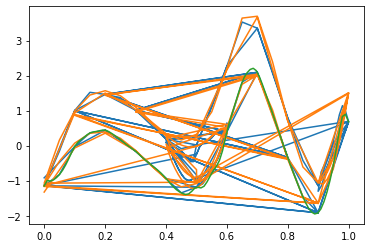

In [7]:
fig, ax = plt.subplots()
H.fitting()
m_pred = H(h_train).clone()
h_norm, m_train_trans = H.transformer.transform(h_train, m_train)
ax.plot(h_norm, m_pred.detach())
ax.plot(h_norm, m_train_trans,'-')

# compare to next
h_test = torch.linspace(*H.valid_domain,100)
h_test_norm = H.transformer.transform(h_test)[0]
H.next()
m_future = H(h_test)
ax.plot(h_test_norm, m_future.detach())


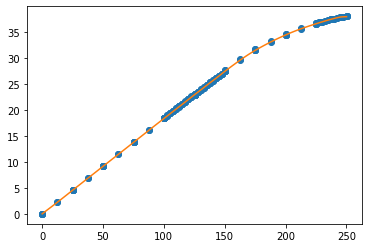

In [8]:
# plot future prediction
fig2, ax2 = plt.subplots()
fig.set_size_inches(10,10)

H.future()

m_future = H(h_test, return_real=True)
ax2.plot(h_train, m_train,'o')
ax2.plot(h_test, m_future.detach())
#ax2.plot(h_train, m_train - fit,'o')

#ax3b = ax3.twinx()
#ax3b.plot(h[n_train:], 'C1')
#print(torch.sqrt(torch.nn.MSELoss()(m_future, m[n_train:])))

In [9]:
torch.save(H, 'aps_model.pt')
